# Learning Snork

## Setup

In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================

!pip install numpy==1.19.5
!pip install pandas==1.1.5
!pip install wget==3.2
!pip install matplotlib==3.2.2
!pip install utils==1.0.1
!pip install snorkel==0.9.6
!pip install scikit-learn==0.21.3
!pip install textblob==0.15.3
!pip install treedlib==0.1.3
!pip install numbskull==0.1.1
!pip install spacy==2.2.4
!pip install tensorflow==1.15
!pip install tensorboard==1.15
!python -m spacy download en_core_web_sm
# ===========================

  Using cached snorkel-0.9.6-py3-none-any.whl (144 kB)
  Using cached networkx-2.3.zip (1.7 MB)
     |████████████████████████████████| 3.8 MB 7.5 MB/s 
  Using cached scikit_learn-0.21.3-cp37-cp37m-manylinux1_x86_64.whl (6.7 MB)
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=d3b5ef2bcdeb5d7050bcfb0b9e7f3567101ba50296f9e7dcfcc3808e34d170de
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfu

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!git clone https://github.com/snorkel-team/snorkel-tutorials.git

source = "content/"
destination = "snorkel-tutorials/spam/data/"

os.makedirs(destination, exist_ok= True)

files = os.listdir(source)

for file in files:
    new_path = shutil.move(f"{source}/{file}", destination)

os.chdir("snorkel-tutorials/spam")

Cloning into 'snorkel-tutorials'...
remote: Enumerating objects: 1104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1104 (delta 14), reused 18 (delta 8), pack-reused 1059
Receiving objects: 100% (1104/1104), 3.53 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (729/729), done.


In [6]:
import re
import glob

import utils

from snorkel.analysis import get_label_buckets

from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling.lf.nlp import nlp_labeling_function

from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor

from snorkel.utils import probs_to_preds

from textblob import TextBlob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Getting the Dataset

In [5]:
import os
import wget

import zipfile
import shutil

file_link = "http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip"

os.makedirs("content", exist_ok= True)
if not os.path.exists("content/YouTube-Spam-Collection-v1.zip"):
    wget.download(file_link, out="content/")
else:
    print("File already exists")

with zipfile.ZipFile("content/YouTube-Spam-Collection-v1.zip", 'r') as zip_ref:
    zip_ref.extractall("content/")

shutil.rmtree("content/__MACOSX")
os.remove("content/YouTube-Spam-Collection-v1.zip")
os.listdir("content")

['Youtube02-KatyPerry.csv',
 'Youtube03-LMFAO.csv',
 'Youtube05-Shakira.csv',
 'Youtube01-Psy.csv',
 'Youtube04-Eminem.csv']

In [7]:
def load_spam_dataset(load_train_labels: bool = False, split_dev_valid: bool = False):
    filenames = sorted(glob.glob("data/Youtube*.csv"))
    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])
    df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev_valid:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_test

In [8]:
df_train, df_test = load_spam_dataset()
print("Train")
display(df_train.head())
print('Test')
df_test.head()

Train


,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1


Test


,author,date,text,label,video
27,‫حلم الشباب‬‎,2015-05-25T23:42:49.533000,Check out this video on YouTube:﻿,1,5
194,MOHAMED THASLEEM,2015-05-24T07:03:59.488000,super music﻿,0,5
277,AlabaGames,2015-05-22T00:31:43.922000,Subscribe my channel I RECORDING FIFA 15 GOAL...,1,5
132,Manish Ray,2015-05-23T08:55:07.512000,This song is so beauty,0,5
163,Sudheer Yadav,2015-05-28T10:28:25.133000,SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...,1,5


In [36]:
Y_test = df_test.label.values


In [9]:
ABSTAIN = -1
HAM = 0
SPAM = 1

## Snorkel

### Labeling Function

In [11]:
@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN

@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

@labeling_function()
def my_channel(x):
    return SPAM if "my channel" in x.text.lower() else ABSTAIN

@labeling_function()
def if_subscribe(x):
    return SPAM if "subscribe" in x.text.lower() else ABSTAIN

In [12]:
# Using our labeling function with df
lfs = [check_out, check, lf_contains_link, my_channel, if_subscribe]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 16648.27it/s]


In [13]:
# Sneak peak after applied
L_train

array([[-1, -1,  1, -1, -1],
       [-1, -1, -1, -1,  1],
       [-1,  1, -1, -1, -1],
       ...,
       [ 1,  1, -1,  1,  1],
       [-1,  1, -1, -1,  1],
       [ 1,  1, -1, -1, -1]])

### Coverage

In [14]:
coverage_check_out, coverage_check, coverage_link, coverage_my_channel, coverage_subscribe= (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")
print(f"link coverage: {coverage_link * 100:.1f}%")
print(f"my_channel coverage: {coverage_my_channel * 100:.1f}%")
print(f"if_subscribe coverage: {coverage_subscribe * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%
link coverage: 11.9%
my_channel coverage: 7.0%
if_subscribe coverage: 12.7%


### LFAnalysis

In [15]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
lf_contains_link,2,[1],0.119168,0.011980,0.0
my_channel,3,[1],0.069987,0.057377,0.0
if_subscribe,4,[1],0.127364,0.054855,0.0


### Combining two labeling functions test

In [16]:
buckets = get_label_buckets(L_train[:, 0], L_train[:, 3])

df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
230,LBEProductions,2014-11-12T01:40:22,Hey guys can you check my channel out plz. I d...,-1.0,1
287,DERRICK HANFORD,2014-12-05T22:52:29.316000,White people are going extinct for more inform...,-1.0,3
113,Carlos Thegamer,2013-12-01T01:20:21,subscribe to my channel people :D﻿,-1.0,1
301,Ractive,NaN,i been working so hard for the past 60 days to...,-1.0,4
246,Patrik Gybka,2015-05-05T09:32:04.687000,SUBSCRIBE MY CHANNEL PLEASE LOL PRO PLAYS)﻿,-1.0,3
8,Youyou A.,2014-10-21T15:20:49,"I make guitar covers, please have a look at my...",-1.0,2
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
171,MR magic man,2014-09-25T10:42:47,Please look at my channel﻿,-1.0,2
10,Dany PK,NaN,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,-1.0,4


## Trying Regex Based Labeling Functions

In [17]:
#using regular expressions
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [18]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 1586/1586 [00:00<00:00, 23118.51it/s]


In [19]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [20]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=2020)

,author,date,text,label,video
112,ArioseRose,2014-11-13T15:20:31,"Don't mind me, I'm just checking what the view...",-1.0,1
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
190,Warrdrew,2014-11-07T07:46:57,I'm here to check the views.. holy shit﻿,-1.0,1
146,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,-1.0,1
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
191,RezAIIDay,2014-11-05T22:50:58,Such a good song ans Katy sounds great over th...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
162,Owen Lai,2013-12-01T04:51:52,just checking the views﻿,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
322,Minecraft-Viasat,2014-11-03T14:38:53,Check my channel﻿,-1.0,1


### Third Party Model TextBlob Labeling Function

In [21]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [22]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN


In [23]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)


100%|██████████| 1586/1586 [00:01<00:00, 977.94it/s] 


In [24]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


### More Labeling Functions! (Knowledge based, NLP based etc)

In [25]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)


In [26]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [27]:
# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [28]:
#snorkel has a pre built labeling function like decorator that uses spaCy as it is a very common nlp preprocessor

@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN


## Results

In [29]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]


In [30]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:03<00:00, 81.61it/s]


In [31]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.186003,0.110340
keyword_subscribe,1,[1],0.127364,0.107818,0.068096
keyword_http,2,[1],0.119168,0.102144,0.083228
keyword_please,3,[1],0.112232,0.109710,0.057377
keyword_song,4,[0],0.141866,0.111602,0.043506
regex_check_out,5,[1],0.233922,0.133039,0.086381
short_comment,6,[0],0.225725,0.144388,0.074401
has_person_nlp,7,[0],0.082598,0.060530,0.025221
textblob_polarity,8,[0],0.035309,0.032156,0.005044
textblob_subjectivity,9,[0],0.357503,0.261665,0.160151


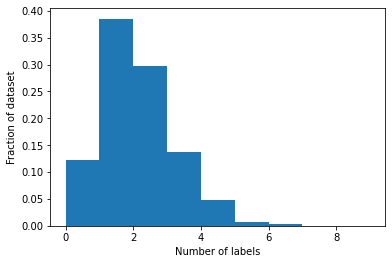

In [32]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [33]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [34]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [37]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   84.0%
Label Model Accuracy:     86.4%


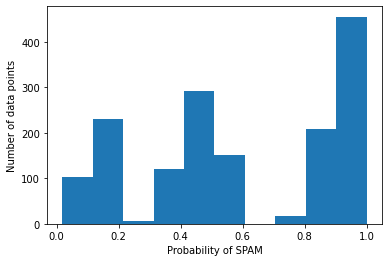

In [38]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])


In [39]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## Training!

In [40]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())


In [41]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [42]:
sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 94.0%
